# Los Angeles Exploration & Visualization

The San Francisco Bay Area was of interest since the wildfires directly affected us in living in the area. The 2020 wildfires, however, largely affected California as a whole, so we also wanted explore the changes and trends in air quality in areas outside of San Francisco. Specifically, we looked into the Los Angeles area since it historically has had the worst air quality in all of California. 

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openaq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style="darkgrid")

import numpy as np
from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import geoplot as gplt
import geoplot.crs as gcrs

import fiona

import imageio
import os

import IPython
from IPython.core.display import Image

In [3]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)

In [4]:
la = api.locations(city='Los Angeles-Long Beach-Santa Ana', df=True)
la.head()

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
0,1052,US,Los Angeles-Long Beach-Santa Ana,[Los Angeles-Long Beach-Santa Ana],Pomona,[Pomona],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-11 18:00:00+00:00,"[co, no2, o3]","[{'parameter': 'co', 'count': 96231}, {'parame...",289411,34.0667,-117.7506
1,1200,US,Los Angeles-Long Beach-Santa Ana,[Los Angeles-Long Beach-Santa Ana],Glendora - Laurel,[Glendora - Laurel],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-11 18:00:00+00:00,"[pm25, no2, pm10, o3, co]","[{'parameter': 'pm25', 'count': 97957}, {'para...",484557,34.1439,-117.8508
2,1948,US,Los Angeles-Long Beach-Santa Ana,[Los Angeles-Long Beach-Santa Ana],Compton,[Compton],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-11 18:00:00+00:00,"[no2, pm25, o3, co]","[{'parameter': 'no2', 'count': 94042}, {'param...",329063,33.9014,-118.2050
3,1989,US,Los Angeles-Long Beach-Santa Ana,[Los Angeles-Long Beach-Santa Ana],Santa Clarita,[Santa Clarita],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-11 18:00:00+00:00,"[co, no2, o3, pm25]","[{'parameter': 'co', 'count': 95956}, {'parame...",388830,34.3833,-118.5283
4,2138,US,Los Angeles-Long Beach-Santa Ana,[Los Angeles-Long Beach-Santa Ana],Reseda,[Reseda],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-11 18:00:00+00:00,"[no2, co, o3, pm25]","[{'parameter': 'no2', 'count': 92881}, {'param...",386486,34.1992,-118.5331


## Mapping Cities in the Los Angeles Area

After querying into the OpenAQ dataset, we map the points in the Los Angeles-Long Beach-Santa Ana area that are included in the queried dataframe.

<AxesSubplot:>

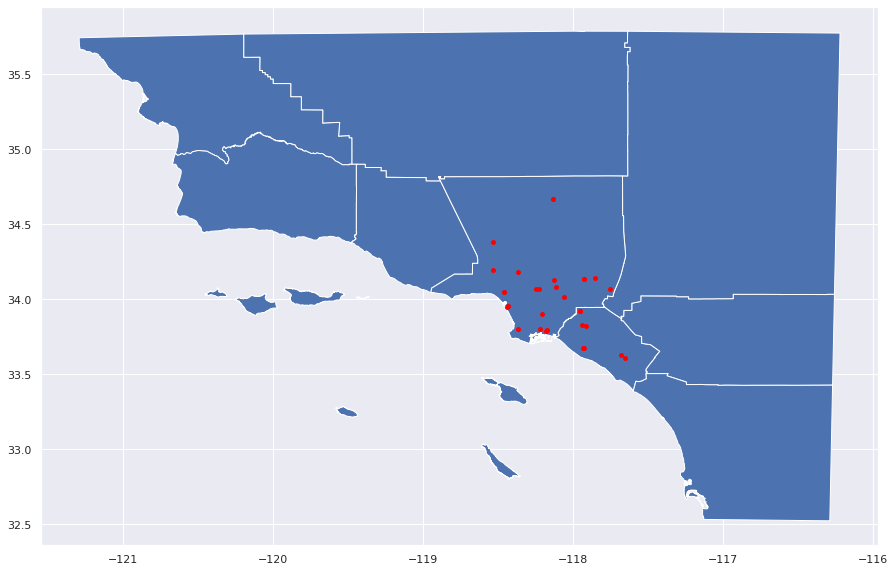

In [5]:
geometry = [Point(xy) for xy in zip(la['coordinates.longitude'], la['coordinates.latitude'])]
gdf = GeoDataFrame(la, geometry=geometry)
world = gpd.read_file("https://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Political_Boundaries/MapServer/18/query?outFields=*&where=1%3D1&f=geojson")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

In [7]:
la_measure = api.measurements(city='Los Angeles-Long Beach-Santa Ana', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
la_measure.groupby(['location'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Anaheim,99.0,7.894949,3.088933,-0.4,6.20,8.0,9.900,15.9
Compton,99.0,11.219192,3.350714,2.7,9.10,11.3,13.250,19.0
Glendora - Laurel,99.0,6.520202,3.980821,0.0,3.35,6.4,8.950,18.6
Lancaster-Division,114.0,7.385965,3.480690,2.0,5.00,7.0,9.000,22.0
Long Beach Signal Hi,99.0,9.106061,2.635156,3.5,7.50,8.8,10.800,17.7
Los Angeles - N. Mai,96.0,11.502083,3.080122,3.9,9.70,11.4,13.575,18.5
Mission Viejo,99.0,13.965657,4.216855,6.9,10.65,13.7,17.100,23.4
North Holywood,99.0,11.792929,3.454404,3.1,9.90,11.7,13.500,21.0
Reseda,97.0,10.483505,4.561448,2.2,7.80,9.8,12.400,25.5


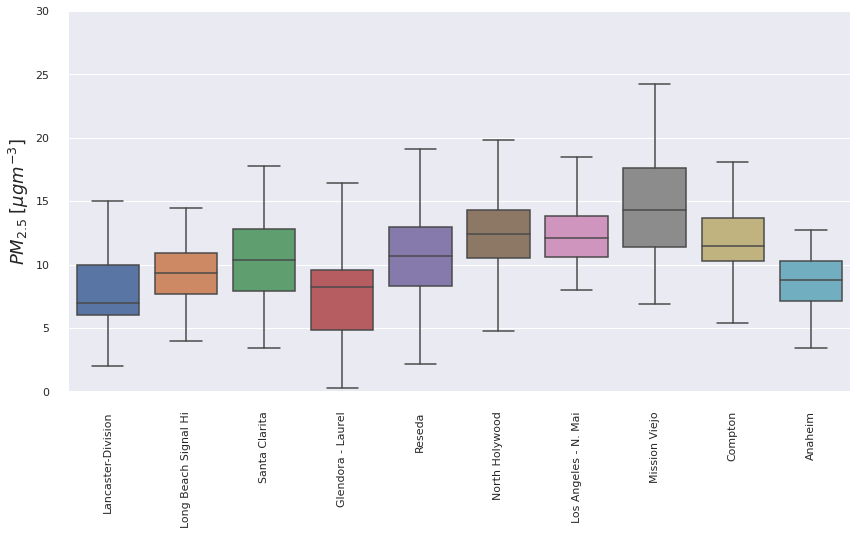

In [10]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location',
    y='value',
    data=la_measure.query("value >= 0.0"),
    fliersize=0,
    palette='deep',
    ax=ax)

ax.set_ylim([0, 30])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

## Comparing Air Quality for Dark Days vs. Average Days

We then compare the air quality in Los Angeles around the dark days and on average days (May 3th to 10th 2022), and compare this difference in air quality in LA with the difference in air quality in SF. 

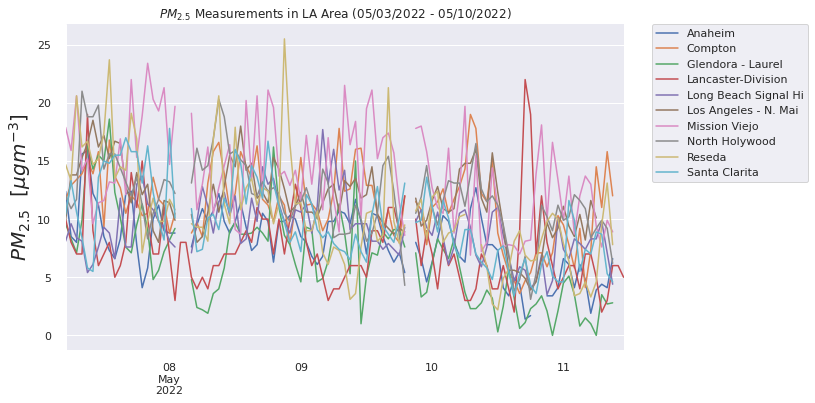

In [30]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in la_measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle("$PM_{2.5}$ Measurements in LA Area (05/03/2022 - 05/10/2022)", y=0.92)

plt.show()


In [31]:
dark_days_LA = api.measurements(city='Los Angeles-Long Beach-Santa Ana', param="pm25", date_from='2020-09-07', date_to='2020-09-17', limit=10000, df=True)

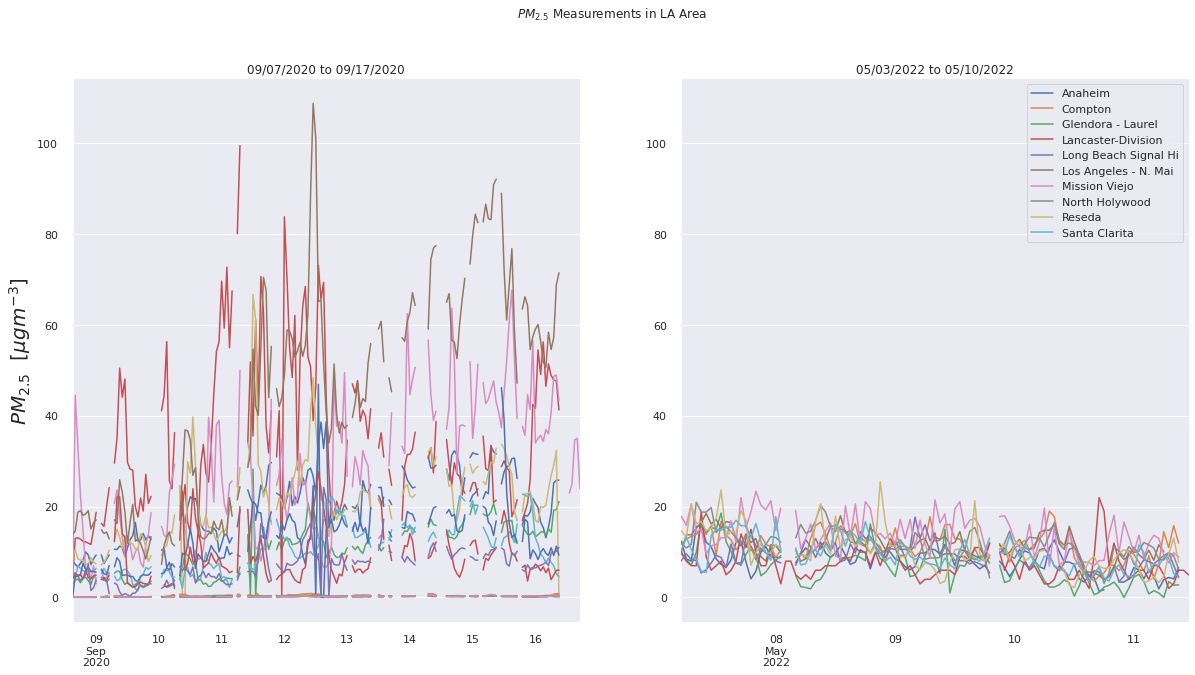

In [38]:
fig= plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharey=ax1)
for group, df in la_measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()
    _df.value.plot(ax=ax2, label=group)
for group, df in dark_days_LA.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()
    _df.value.plot(ax=ax1, label=group)
    
plt.legend(loc='best')
ax1.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax2.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax1.set_xlabel("")
ax2.set_xlabel("")
sns.despine(offset=5)
ax1.set_title('09/07/2020 to 09/17/2020')
ax2.set_title('05/03/2022 to 05/10/2022')

plt.suptitle("$PM_{2.5}$ Measurements in LA Area", y=0.98)
plt.show()

As seen in these two compared visualizations, we can see that compared to a normal day in LA exhibited through the May 2022 air quality datasets, which averages a PM2.5 value of approximately 15, the air quality in the dark days were significantly higher. 

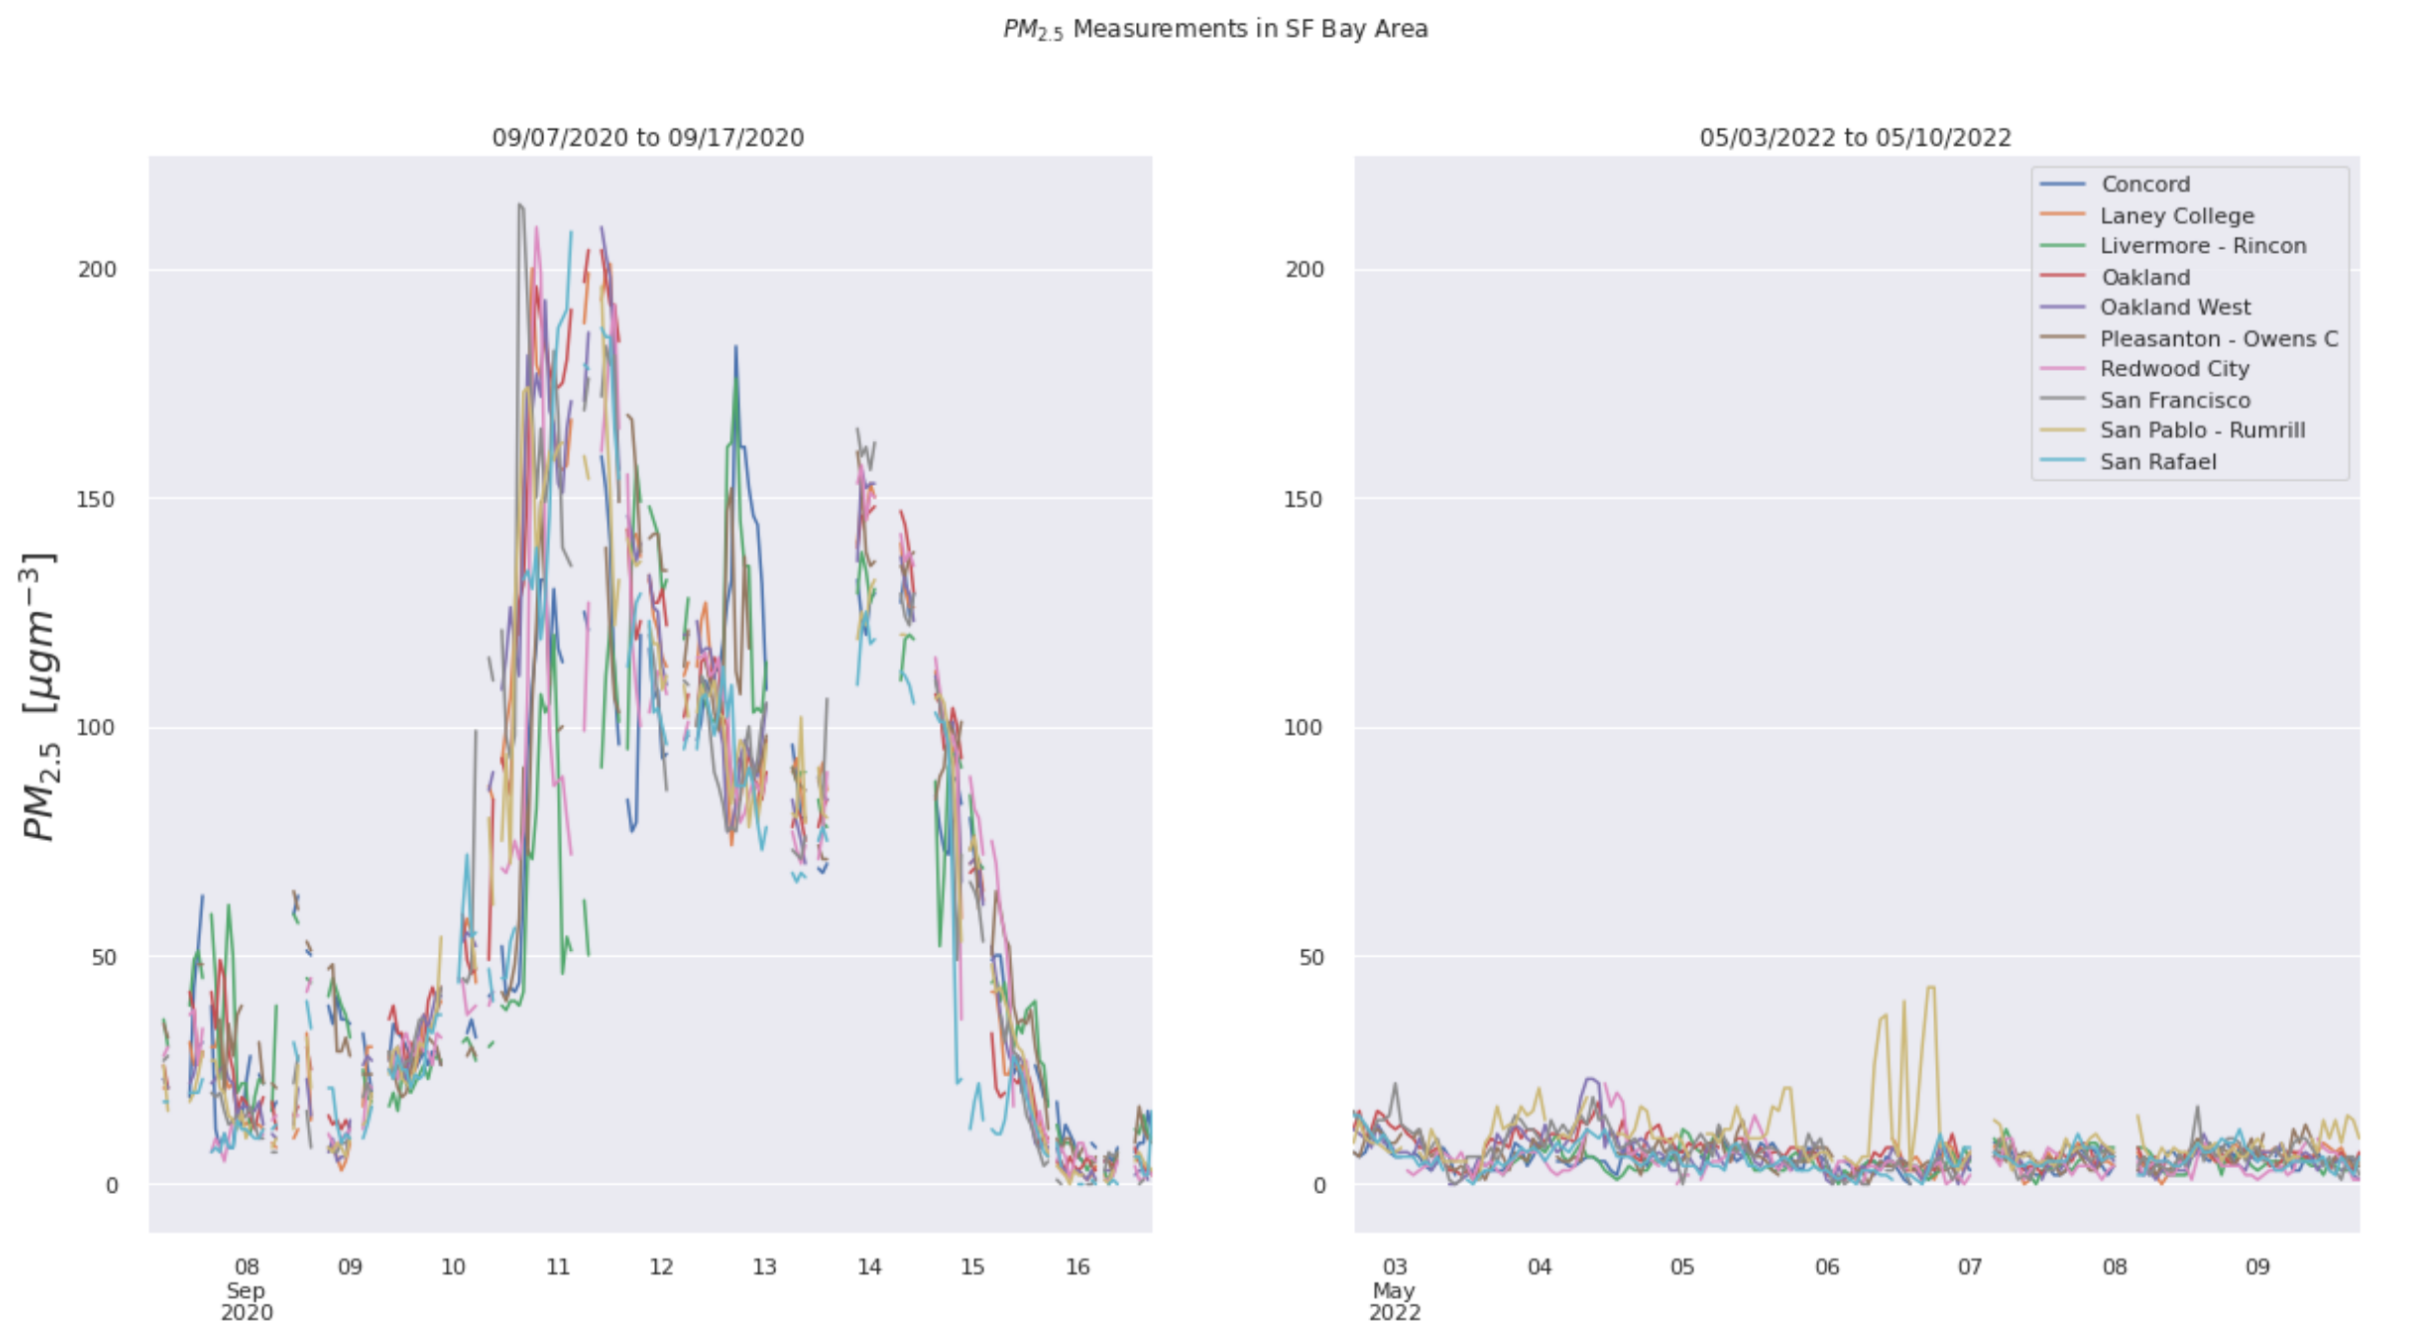

In [37]:
Image(filename = 'figures/PM25TScompare.png', width=1000, height=1000)

Upon comparing the two LA visualizations with the SF visualizations, we can see that although on a normal day, the air quality in Los Angeles is worse than San Francisco, the air quality in SF around the "dark day" was worse than that in LA. This makes sense, since the air quality in San Francisco was visibly poor with orange skies, whereas there were no strong visible indications of the poor air quality in Los Angeles around that time. 